# 숙명여자대학교 기계시스템학부 딥러닝 2025: Lab4

## Topic: **Segmentation & Object Detection**
## (강사: 심주용)


# 1.Fully Convolutional Networks (FCN)

- FCN is built only from locally connected layers, such as convolution, pooling and upsampling.
- Note that no dense layer is used in this kind of architecture.
- Network can work regardless of the original image size, without requiring any fixed number of units at any stage.
- To obtain a segmentation map (output), segmentation networks usually have 2 parts

    1. Downsampling path: capture semantic/contextual information
    2. Upsampling path: recover spatial information

- The downsampling path is used to extract and interpret the context (what), while the upsampling path is used to enable precise localization (where).
- Furthermore, to fully recover the fine-grained spatial information lost in the pooling or downsampling layers, we often use skip connections.
- Given a position on the spatial dimension, the output of the channel dimension will be a category prediction of the pixel corresponding to the location.

https://i-systems.github.io/teaching/DL/iNotes_tf2/12_FCN_tf2.html


## 1.1 Dataset for Segmentation

In an image classification task, the network assigns a label (or class) to each input image. However, suppose you want to know the shape of that object, which pixel belongs to which object, etc. In this case, you need to assign a class to each pixel of the image—this task is known as segmentation. A segmentation model returns much more detailed information about the image. Image segmentation has many applications in medical imaging, self-driving cars and satellite imaging, just to name a few.

- Segmentation task is different from classification task because it requires predicting a class for each pixel of the input image, instead of only 1 class for the whole input.
- Classification needs to understand what is in the input (namely, the context).
- However, in order to predict what is in the input for each pixel, segmentation needs to recover not only what is in the input, but also where.
- Segment images into regions with different semantic categories. These semantic regions label and predict objects at the pixel level


https://www.tensorflow.org/tutorials/images/segmentation

 ![GT](https://www.tensorflow.org/static/tutorials/images/segmentation_files/output_a6u_Rblkteqb_1.png)

In [ ]:
!wget https://www.dropbox.com/s/8eauz8nnill1n8c/images_training.npy
!wget https://www.dropbox.com/s/563go90a7qkioc7/images_testing.npy
!wget https://www.dropbox.com/s/cydl62wezz5ie7a/seg_training.npy

--2025-04-28 08:05:13--  https://www.dropbox.com/s/8eauz8nnill1n8c/images_training.npy
Resolving www.dropbox.com (www.dropbox.com)... 162.125.2.18, 2620:100:6017:18::a27d:212
Connecting to www.dropbox.com (www.dropbox.com)|162.125.2.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.dropbox.com/scl/fi/0dip03rohhr7znragdivm/images_training.npy?rlkey=zyi2wbsm7jl5g9c2f8gwjyund [following]
--2025-04-28 08:05:13--  https://www.dropbox.com/scl/fi/0dip03rohhr7znragdivm/images_training.npy?rlkey=zyi2wbsm7jl5g9c2f8gwjyund
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc46cef3db62fe8626598622108e.dl.dropboxusercontent.com/cd/0/inline/CopoNF-2PU3vHSMUcdOp-RArs55QC0g5wd2dBRqHtqsx4GhclOHPfTeuYj7kwuSj71aElE5qrZlyPDSdYBAeT4mhkMleGXSCJyVlxkhAKw7WyzhAEndqVhrgCyAIr12v_DEFVOu0u1tFq6bJonu4UZht/file# [following]
--2025-04-28 08:05:14--  https://uc46cef3db62fe8626598622108e.dl.dropboxusercont

The number of training images : 180, shape : (180, 224, 224, 3)
The number of segmented images : 180, shape : (180, 224, 224, 2)
The number of testing images : 27, shape : (27, 224, 224, 3)


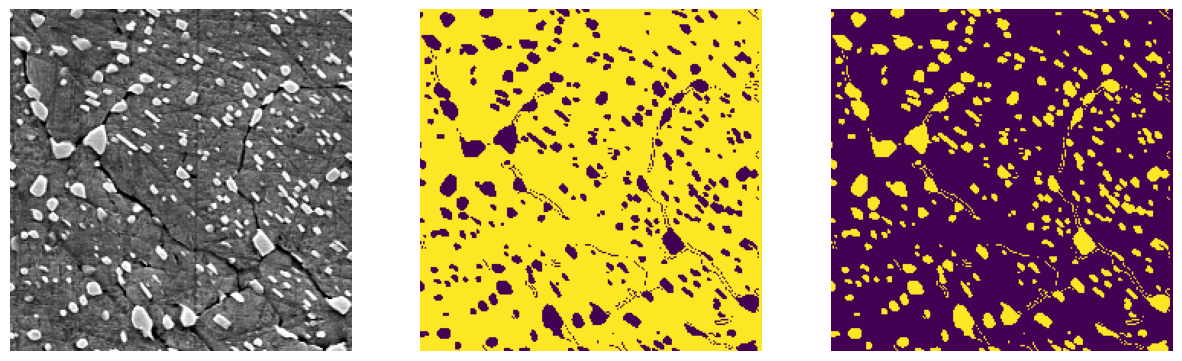

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torchvision.transforms.functional import to_pil_image
import torchvision.models as models

train_imgs = np.load('images_training.npy')
train_seg = np.load('seg_training.npy')
test_imgs = np.load('images_testing.npy')

n_train = train_imgs.shape[0]
n_test = test_imgs.shape[0]

print ("The number of training images : {}, shape : {}".format(n_train, train_imgs.shape))
print ("The number of segmented images : {}, shape : {}".format(n_train, train_seg.shape))
print ("The number of testing images : {}, shape : {}".format(n_test, test_imgs.shape))

idx = np.random.randint(n_train)

plt.figure(figsize = (15,10))
plt.subplot(1,3,1)
plt.imshow(train_imgs[idx])
plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(train_seg[idx][:,:,0])
plt.axis('off')
plt.subplot(1,3,3)
plt.imshow(train_seg[idx][:,:,1])
plt.axis('off')
plt.show()

## 1.2. Utilize VGG16 Model for Encoder

![](https://raw.githubusercontent.com/jooyongsim/AI_tutorials_2023/main/photos/seg_model.png)

In [ ]:
# Load the pre-trained VGG16 model
model_type = models.vgg16
base_model = model_type(pretrained=True)
for param in base_model.parameters():
    param.requires_grad = False
base_model.eval()

# Check the model architecture
print(base_model)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:03<00:00, 167MB/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

## 1.3 CrossEntropyLoss for Segmentation

In [ ]:
target

tensor([1, 0, 1])

In [ ]:
# Example of target with class indices
loss = nn.CrossEntropyLoss()
input = torch.randn(3, 5, requires_grad=True)
target = torch.empty(3, dtype=torch.long).random_(5)
output = loss(input, target)
output.backward()
print(input, target)
output

tensor([[ 0.4041,  0.9035, -1.5753, -1.9472,  1.0403],
        [-1.7308,  1.2588, -0.1508,  0.9491, -1.5433],
        [ 0.8069, -0.8278,  0.3153, -0.8001, -0.9060]], requires_grad=True) tensor([2, 2, 0])


tensor(2.1569, grad_fn=<NllLossBackward0>)

In [ ]:
nn.Softmax(dim=1)(input)

tensor([[0.2096, 0.3454, 0.0290, 0.0200, 0.3960],
        [0.0241, 0.4787, 0.1169, 0.3512, 0.0290],
        [0.4571, 0.0891, 0.2796, 0.0917, 0.0824]], grad_fn=<SoftmaxBackward0>)

In [ ]:
import math
-1/3*(math.log(0.0290) + math.log(0.1169) + math.log(0.4571))

2.156582984381405

In [ ]:
output = torch.nn.NLLLoss()(input, target)
output

tensor(-0.1240, grad_fn=<NllLossBackward0>)

In [ ]:
import math
-1/3*(math.log(0.1683) + math.log(0.0377) + math.log(0.1660))

2.285289950979714

In [ ]:
target

tensor([[0.1003, 0.1459, 0.4263, 0.2845, 0.0430],
        [0.1744, 0.1732, 0.0907, 0.4436, 0.1181],
        [0.1392, 0.0314, 0.4996, 0.0240, 0.3058]])

In [ ]:
# # Example of target with class probabilities
input = torch.randn(3, 5, requires_grad=True)
target = torch.randn(3, 5).softmax(dim=1)
output = loss(input, target)
output.backward()

input, target

(tensor([[-0.4470,  1.4727,  0.3350,  0.2167, -1.8385],
         [-0.3247,  0.1235, -0.9943,  0.2050,  0.5667],
         [-0.0238, -0.3124,  0.0500,  0.0262,  1.2407]], requires_grad=True),
 tensor([[0.1003, 0.1459, 0.4263, 0.2845, 0.0430],
         [0.1744, 0.1732, 0.0907, 0.4436, 0.1181],
         [0.1392, 0.0314, 0.4996, 0.0240, 0.3058]]))

## 1.4 Build a FCN Model
- nn.ConvTranspose2d are used to define upsampling parts
![](https://raw.githubusercontent.com/jooyongsim/AI_tutorials_2023/main/photos/seg_model.png)

In [ ]:
import torch
import torchvision.models as models
from torch import nn

# Load the pre-trained VGG16 model
model_type = models.vgg16
base_model = model_type(pretrained=True)
for param in base_model.parameters():
    param.requires_grad = True

# Modify the model by creating a new class that inherits from nn.Module
class SegModel(nn.Module):
    def __init__(self):
        super(SegModel, self).__init__()
        # Adding new layers
        self.conv6 = nn.Conv2d(512, 4096, kernel_size=(7, 7), padding='same')
        self.relu6 = nn.ReLU(inplace=True)

        self.fcn4 = nn.Conv2d(4096, 4096, kernel_size=(1, 1))
        self.reluf4 = nn.ReLU(inplace=True)

        self.fcn3 = nn.Conv2d(4096, 2, kernel_size=(1, 1))
        self.reluf3 = nn.ReLU(inplace=True)

        # Upsampling layers
        self.fcn2 = nn.ConvTranspose2d(2, 512, kernel_size=(4, 4), stride=(2, 2), padding=1)

        # Custom operation to add output of a middle layer in VGG16 to our upsampled output
        self.vgg_mid3 = nn.Sequential(*list(base_model.features.children())[:17])
        # Capturing output of layer 16 (1/8)

        self.vgg_mid4 = nn.Sequential(*list(base_model.features.children())[17:24])
        # Capturing output of layer 24 (1/16)

        self.vgg_mid5 = nn.Sequential(*list(base_model.features.children())[24:])
        # Capturing output of layer 30 (1/32)

        self.fcn1 = nn.ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=1)

        self.output_layer = nn.ConvTranspose2d(256, 2, kernel_size=(16, 16), stride=(8, 8), padding=4)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        mid3 = self.vgg_mid3(x)
        mid4 = self.vgg_mid4(mid3)
        mid5 = self.vgg_mid5(mid4)
        x = self.conv6(mid5)
        x = self.relu6(x)
        x = self.fcn4(x)
        x = self.reluf4(x)
        x = self.fcn3(x)
        x = self.reluf3(x)
        x = self.fcn2(x)
        x = self.fcn1(x + mid4)
        x = self.output_layer(x + mid3)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Instantiate the model
seg_model = SegModel().to(device)

# Print model summary (PyTorch does not have an equivalent to Keras' model.summary(); use torchsummary for a similar output)
from torchsummary import summary
summary(seg_model, input_size=(3, 224, 224))


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

## 1.4. Training

In [ ]:
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torchvision.transforms as transforms

# Convert numpy arrays to torch tensors
train_imgs_tensor = torch.tensor(train_imgs).float()
train_seg_tensor = torch.tensor(train_seg).long()  # Use long for target segmentation maps

# Ensure the segmentation masks are in the correct format (channel last to channel first)
train_imgs_tensor = train_imgs_tensor.permute(0, 3, 1, 2)
train_seg_tensor = train_seg_tensor.permute(0, 3, 1, 2)

# Create a TensorDataset and DataLoader
train_dataset = TensorDataset(train_imgs_tensor, train_seg_tensor)
train_loader = DataLoader(train_dataset, batch_size=5, shuffle=True)

# Setup the optimizer and the loss function
optimizer = optim.Adam(seg_model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Define the number of epochs
num_epochs = 5

# Training loop
for epoch in range(num_epochs):
    seg_model.train()  # Set model to training mode
    running_loss = 0.0

    for images, masks in train_loader:
        # Move tensors to the configured device
        images = images.to(device)
        masks = masks.to(device).to(torch.float32)

        # Forward pass: compute predicted outputs by passing inputs to the model
        outputs = seg_model(images)

        # Calculate the loss
        loss = criterion(outputs, masks)  # assuming masks are (N, C, H, W) and C=1

        # Backward pass: compute gradient of the loss with respect to model parameters
        optimizer.zero_grad()
        loss.backward()

        # Perform a single optimization step (parameter update)
        optimizer.step()

        # Update running training loss
        running_loss += loss.item() * images.size(0)

    # Print average loss for the epoch
    epoch_loss = running_loss / len(train_loader.dataset)
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch + 1, epoch_loss))

print('Finished Training')

Epoch: 1 	Training Loss: 0.433102
Epoch: 2 	Training Loss: 0.258432
Epoch: 3 	Training Loss: 0.211086
Epoch: 4 	Training Loss: 0.191406
Epoch: 5 	Training Loss: 0.178640
Finished Training


## 1.5. Testing

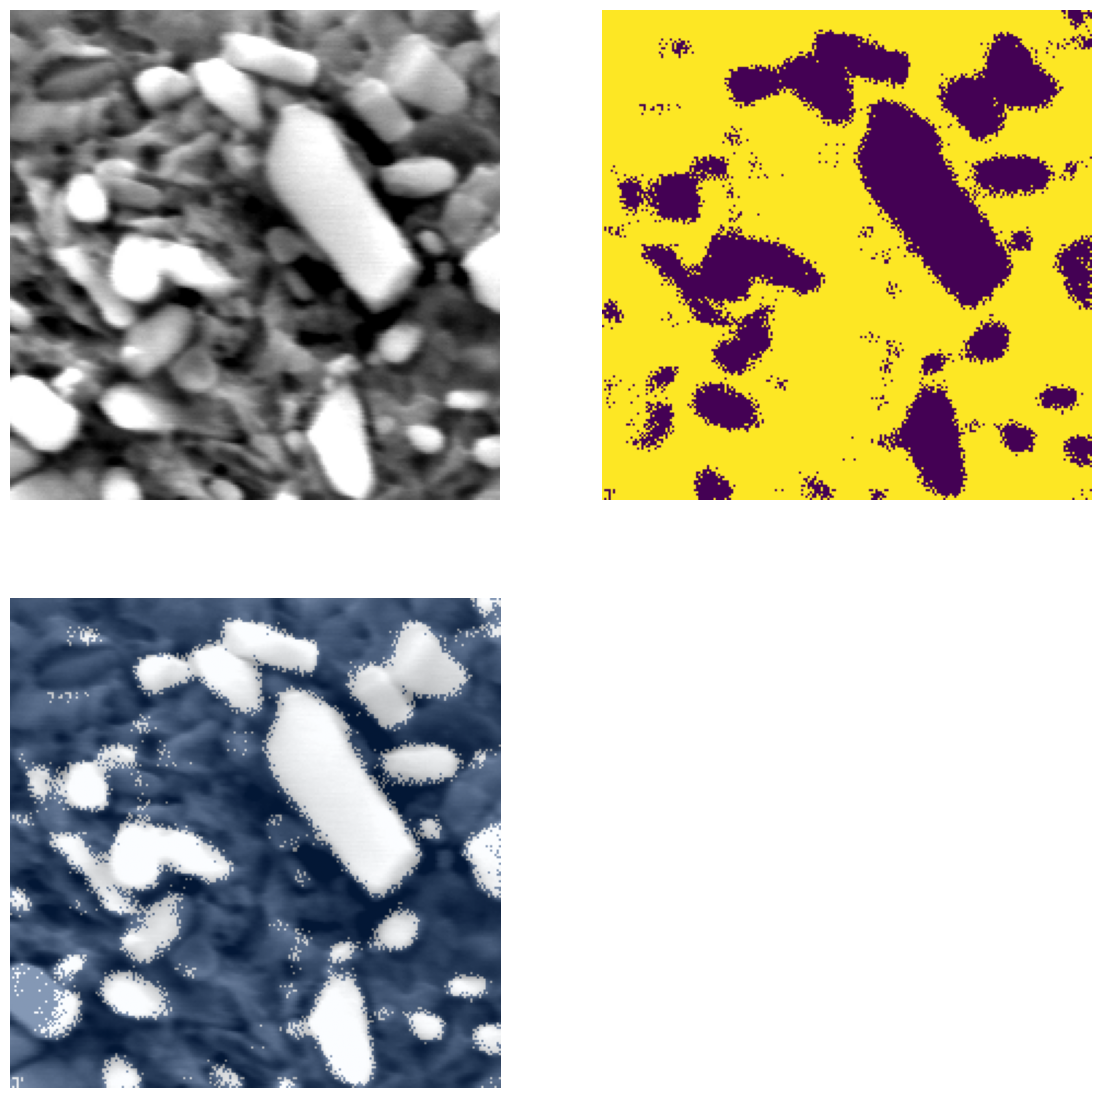

In [ ]:
test_x = test_imgs[[1]]
test_x = torch.tensor(test_x).float().to(device)
test_x = test_x.permute(0, 3, 1, 2)

seg_model.eval()
test_seg = seg_model(test_x)
# test_seg = test_seg.permute(0, 2, 3, 1)

# seg_mask = (test_seg[0,1,:,:]).reshape(224, 224, 1).detach().cpu().numpy()
seg_mask = (test_seg[0,0,:,:]>0).detach().cpu().numpy()

img = test_x[0].permute(1, 2, 0).cpu().numpy()
plt.show()
plt.figure(figsize = (14,14))
plt.subplot(2,2,1)
plt.imshow(img)
plt.axis('off')
plt.subplot(2,2,2)
plt.imshow(seg_mask)
plt.axis('off')
plt.subplot(2,2,3)
plt.imshow(img)
plt.imshow(seg_mask, cmap = 'Blues', alpha = 0.5)
plt.axis('off')
plt.show()

# 2.Object Detection
![](https://raw.githubusercontent.com/jooyongsim/AI_tutorials_2023/main/photos/od_model.png)

## 2.1 Load Machinery Parts Dataset
- 2-D convolution layers extract features from the input image.
- Extracted features are utilized for object bounding box detection and object classification
- Both classifier and bounding box regressor share the same features acuired from the 2-D convolution layers

https://i-systems.github.io/teaching/DL/iNotes_tf2/15_Object_Detection_tf2.html

In [ ]:
!wget https://www.dropbox.com/s/q018u8xjpgw1o08/object_detction_trn_data.npy
!wget https://www.dropbox.com/s/n2tbpv711noece1/object_detction_trn_label.npy
!wget https://www.dropbox.com/s/sup33lt7hmpml49/object_detction_eval_data.npy
!wget https://www.dropbox.com/s/2xi5naxkyw8a4cz/object_detction_eval_label.npy

--2025-04-28 08:26:56--  https://www.dropbox.com/s/q018u8xjpgw1o08/object_detction_trn_data.npy
Resolving www.dropbox.com (www.dropbox.com)... 162.125.66.18, 2620:100:6022:18::a27d:4212
Connecting to www.dropbox.com (www.dropbox.com)|162.125.66.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.dropbox.com/scl/fi/6tp8yco81ccmmj4do6rpm/object_detction_trn_data.npy?rlkey=diznka1ddaxl1zu91nipwktus [following]
--2025-04-28 08:26:56--  https://www.dropbox.com/scl/fi/6tp8yco81ccmmj4do6rpm/object_detction_trn_data.npy?rlkey=diznka1ddaxl1zu91nipwktus
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc052098a7105c141b4345dd578f.dl.dropboxusercontent.com/cd/0/inline/Cop85p20ih7yl8Slemh7H0yRhhPKwqHweBLonkrvI8a3U2eKuJtP_umciPiStSBBT9Km9Qz3RDHduJMISvzv4U8HFSy-wnzzxhbLwl5ypklcQ51pU6gluh1TjnqLCbfmwA9bbo6qyfvdXft2XieLXML5/file# [following]
--2025-04-28 08:26:57--  https://uc052098a7105c141

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches


# Load data
train_imgs = np.load('object_detction_trn_data.npy')
train_labels = np.load('object_detction_trn_label.npy')
test_imgs = np.load('object_detction_eval_data.npy')
test_labels = np.load('object_detction_eval_label.npy')

# Classes
classes = ['Axis', 'Bearing', 'Bearing_Box', 'Distance_Tube', 'F20_20_B']

- Five classes images are availabe: Axis, bearing, bearing box, distance tube, beam

- 250 images are used for training (50 images per class)

- 50 images are avalialbe for evaluation (10 images per class)

- One object per image (240 by 320)

- Labeled with class and bounding box location(normalizsed): class,  x,y,h,w

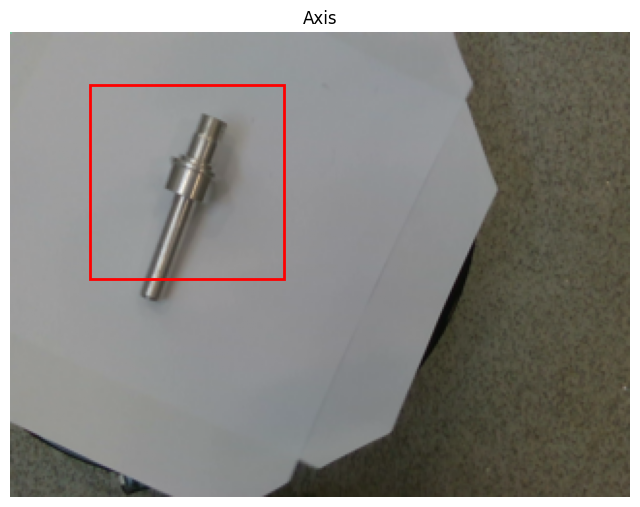

In [ ]:
idx = 138

train_img = train_imgs[idx]
c, x, y, h, w = train_labels[idx]

# rescaling
x, w = x*320, w*320
y, h = y*240, h*240

rect = patches.Rectangle((x, y),
                         w,
                         h,
                         linewidth = 2,
                         edgecolor = 'r',
                         facecolor = 'none')

fig, ax = plt.subplots(figsize = (8,8))
plt.title(classes[int(c)])
plt.imshow(train_img)
ax.add_patch(rect)
plt.axis('off')
plt.show()

In [ ]:
# Rescale labels
train_labels = np.multiply(train_labels, [1, 320, 240, 240, 320])
test_labels = np.multiply(test_labels, [1, 320, 240, 240, 320])

# Convert to tensors
train_imgs_tensor = torch.tensor(train_imgs).float().permute(0, 3, 1, 2)  # Convert NHWC to NCHW
train_labels_tensor = torch.tensor(train_labels).float()
train_cls_tensor = train_labels_tensor[:, 0].long()
train_bbox_tensor = train_labels_tensor[:, 1:]

# Datasets and Dataloaders
train_dataset = TensorDataset(train_imgs_tensor, train_cls_tensor, train_bbox_tensor)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)


## 2.2. Define and Build an Object Detection Model

![](https://raw.githubusercontent.com/jooyongsim/AI_tutorials_2023/main/photos/od_model.png)

In [ ]:
# Model definition
class FeatureExtractor(nn.Module):
    def __init__(self):
        super(FeatureExtractor, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(128, 256, 3, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d(1)  # Global Average Pooling
        )

    def forward(self, x):
        return self.features(x)

class ObjectDetectionModel(nn.Module):
    def __init__(self):
        super(ObjectDetectionModel, self).__init__()
        self.feature_extractor = FeatureExtractor()
        self.classifier = nn.Sequential(
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 5),
        )
        self.bb_regressor = nn.Sequential(
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 4)
        )

    def forward(self, x):
        features = self.feature_extractor(x).view(-1, 256)
        return self.classifier(features), self.bb_regressor(features)

# Initialize the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
od_model = ObjectDetectionModel().to(device)


## 2.3. Define Losses and Optimization Configuration


In [ ]:
# Loss functions and optimizer
cls_criterion = nn.CrossEntropyLoss()
bbox_criterion = nn.MSELoss()
optimizer = optim.Adam(od_model.parameters(), lr=0.001)

# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    od_model.train()
    for imgs, clss, bboxes in train_loader:
        imgs, clss, bboxes = imgs.to(device), clss.to(device), bboxes.to(device)
        optimizer.zero_grad()
        output_clss, output_bboxes = od_model(imgs)
        loss_cls = cls_criterion(output_clss, clss)
        loss_bbox = bbox_criterion(output_bboxes, bboxes)
        loss = loss_cls + loss_bbox
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch+1}, Loss: {loss.item()}')

# Prediction for visualization can be implemented similarly using the model's .eval() method


Epoch 1, Loss: 1871.6861572265625
Epoch 2, Loss: 2035.36083984375
Epoch 3, Loss: 481.24884033203125
Epoch 4, Loss: 1980.5645751953125
Epoch 5, Loss: 1051.906005859375
Epoch 6, Loss: 1517.7554931640625
Epoch 7, Loss: 1489.2314453125
Epoch 8, Loss: 625.7764892578125
Epoch 9, Loss: 2169.716552734375
Epoch 10, Loss: 1428.2569580078125
Epoch 11, Loss: 1727.2144775390625
Epoch 12, Loss: 1434.1990966796875
Epoch 13, Loss: 1776.6806640625
Epoch 14, Loss: 1783.717529296875
Epoch 15, Loss: 1081.3486328125
Epoch 16, Loss: 1944.1943359375
Epoch 17, Loss: 1923.7264404296875
Epoch 18, Loss: 715.6536254882812
Epoch 19, Loss: 1079.7593994140625
Epoch 20, Loss: 1510.1405029296875
Epoch 21, Loss: 648.6011962890625
Epoch 22, Loss: 802.876953125
Epoch 23, Loss: 623.1812133789062
Epoch 24, Loss: 412.178466796875
Epoch 25, Loss: 330.2188415527344
Epoch 26, Loss: 366.82891845703125
Epoch 27, Loss: 253.22142028808594
Epoch 28, Loss: 444.8093566894531
Epoch 29, Loss: 325.6886291503906
Epoch 30, Loss: 295.09713

## 2.4. Check Training Results


Bearing
Bearing


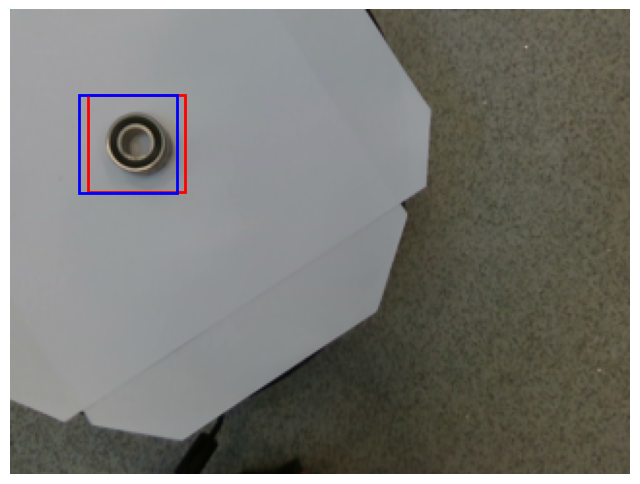

In [ ]:
idx = 110

# true label
c_label, x_label, y_label, h_label, w_label = train_labels[idx]

rect_label = patches.Rectangle((x_label, y_label),
                               w_label,
                               h_label,
                               linewidth = 2,
                               edgecolor = 'r',
                               facecolor = 'none')

# predict
c_pred, bbox = od_model(train_imgs_tensor[idx].to(device))
c_pred, bbox = c_pred.detach().cpu().numpy(), bbox.detach().cpu().numpy()

x, y, h, w = bbox[0]
rect = patches.Rectangle((x, y),
                         w,
                         h,
                         linewidth = 2,
                         edgecolor = 'b',
                         facecolor = 'none')
print(classes[int(c_label)])
print(classes[np.argmax(c_pred)])

fig, ax = plt.subplots(figsize = (8,8))
plt.imshow(train_imgs[idx])
ax.add_patch(rect_label)
ax.add_patch(rect)
plt.axis('off')
plt.show()

## 2.5. Check Evaluation Results


Bearing_Box
Bearing_Box


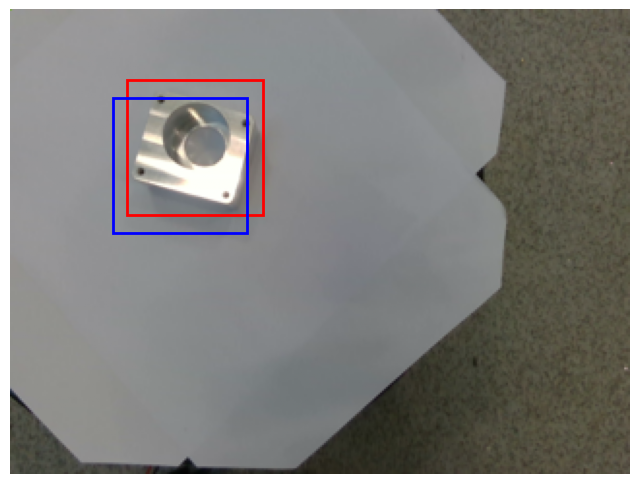

In [ ]:
idx = 50

# true label
c_label, x_label, y_label, h_label, w_label = train_labels[idx]

rect_label = patches.Rectangle((x_label, y_label),
                               w_label,
                               h_label,
                               linewidth = 2,
                               edgecolor = 'r',
                               facecolor = 'none')

# predict
c_pred, bbox = od_model(train_imgs_tensor[idx].to(device))
c_pred, bbox = c_pred.detach().cpu().numpy(), bbox.detach().cpu().numpy()

x, y, h, w = bbox[0]
rect = patches.Rectangle((x, y),
                         w,
                         h,
                         linewidth = 2,
                         edgecolor = 'b',
                         facecolor = 'none')
print(classes[int(c_label)])
print(classes[np.argmax(c_pred)])

fig, ax = plt.subplots(figsize = (8,8))
plt.imshow(train_imgs[idx])
ax.add_patch(rect_label)
ax.add_patch(rect)
plt.axis('off')
plt.show()